# Homework 7 Template

Rixin Li & G . Besla



In [188]:
# import necessary modules
# numpy provides powerful multi-dimensional arrays to hold and manipulate data
import numpy as np
# matplotlib provides powerful functions for plotting figures
import matplotlib.pyplot as plt
# astropy provides unit system and constants for astronomical calculations
import astropy.units as u
import astropy.constants as const
# import Latex module so we can display the results with symbols
from IPython.display import Latex
%matplotlib inline

# **** import CenterOfMass to determine the COM pos/vel of M33
from CenterOfMass import CenterOfMass

# **** import the GalaxyMass to determine the mass of M31 for each component
from GalaxyMass import ComponentMass

# M33AnalyticOrbit

In [200]:
class M33AnalyticOrbit:
    """ Calculate the analytical orbit of M33 around M31 """
    
    def __init__(self, filename): # **** add inputs
        """ Class to analytically calculate the orbit of the M33 COM relative to M31 COM
        given their initial positions and velocities, and assuming Hernquist profiles
        for the Bulge and Halo components of M31 and a Miyamoto-Nagai profile for the disk.
        
        PARAMETERS
        ----------
        filename: `string`
            name of file to save integrated orbit to
        
        """
        
        # get the gravitational constant (the value is 4.498502151575286e-06)
        self.G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
        
        self.filename = filename # store the output file name

        COM_M33 = CenterOfMass("M33_000.txt", ptype=2) # M33 COM object, disk particles
        r_M33 = COM_M33.COM_P(0.1) # M33 COM iterative position with 0.1 tolerance
        v_M33 = COM_M33.COM_V(r_M33[0], r_M33[1], r_M33[2]) # M33 COM velocity

        COM_M31 = CenterOfMass("M31_000.txt", ptype=2) # M31 COM object, disk particles
        r_M31 = COM_M31.COM_P(0.1) # M31 COM  position vector, 0.1 tolerance iterations
        v_M31 = COM_M31.COM_V(r_M31[0], r_M31[1], r_M31[2]) # M31 COM velocity
        
        self.r0 = (r_M33 - r_M31).value # relative position vector between M31 and M33 (no units)
        self.v0 = (v_M33 - v_M31).value # relative velocity vector between M31 and M33 (no units)
        
        # scale length/mass of each component in M31 (factor of 1e12 due to implicit units)
        self.rdisk = 5 # scale length of M31 disk as stated in HW PDF
        self.Mdisk = ComponentMass('M31_000.txt', 2).value*1e12 # M31 disk mass component
        
        self.rbulge = 1 # scale length of M31 bulge as stated in HW PDF
        self.Mbulge = ComponentMass('M31_000.txt', 3).value*1e12 # M31 bulge mass component
        
        self.rhalo = 62 # scale length of M31 halo from HW 5
        self.Mhalo = ComponentMass('M31_000.txt', 1).value*1e12 # M31 halo mass component
    
    
    def HernquistAccel(self, M, r_a, r):
        """ Function to determine the acceleration vector on M33 from a component of M31 with
        a specified mass, assuming a Hernquist profile (for bulge and halo).
        
        INPUTS
        ------
        M: `float`
            Mass of galaxy component (Msun)
        
        r_a: `float`
            Scale length of galaxy component being analyzed (kpc)
        
        r: `numpy array`
            Position vector of M33 COM, components in kpc
            
        OUTPUTS
        -------
        Hern: `numpy array`
            Acceleration vector of M33 COM from M31 Hernquist profile
        
        """
    
        rmag = np.linalg.norm(r) # Magnitude of the position vector
        
        # Formula for acceleration from Hern. profile given by equation 1 in the HW PDF
        Hern =  -self.G*M / (rmag * (r_a + rmag)**2) * r 
        return Hern # return acceleration vector


    def MiyamotoNagaiAccel(self, M, r_d, r):# it is easiest if you take as an input a position VECTOR  r 
        """ Function to determine the acceleration vector on M33 from a component of M31 with
        a specified mass, assuming a Miyamoto-Nagai 1975 profile (exponential disk profile).
        
        INPUTS
        ------
        M: `float`
            Mass of galaxy component (Msun)
        
        r_d: `float`
            Scale length of galaxy component being analyzed (kpc)
        
        r: `numpy array`
            Position vector of M33 COM, components in kpc
            
        OUTPUTS
        -------
        MN_acceleration: `numpy array`
            Acceleration vector of M33 COM from M31 Miyamoto-Nagai profile
        
        """

        # define three quantities from the HW to simplify the acceleration formula
        z_d = r_d/5.0 # define quantity z_d based on HW PDF instructions
        R = np.sqrt(r[0]**2 + r[1]**2) # another quantity from HW PDF
        B = r_d + np.sqrt(r[2]**2 + z_d**2) # yet another quantity from HW PDF
        
        MN_acceleration = -self.G*M / (R**2 + B**2)**1.5 * r # formula from HW PDF
        # z component contains an additional factor, define vector to multiply by to achieve this
        correction_vector = np.array([1, 1, B/np.sqrt(r[2]**2 + z_d**2)]) 
        MN_acceleration *= correction_vector # add extra term to z component
        return MN_acceleration # return acceleration vector
     
    
    def M31Accel(self, r):
        """ Function to determine the total acceleration on M33 from all components of M31. Its
        bulge and halo are assumed to have a Hernquist profile with scale lengths as given/derived
        in previous hw, and its disk is assumed to follow a Miyamoto-Nagai 1975 profile with a
        scale length given. The acceleration from all three components are then summed.
        
        INPUTS
        ------
        r: `numpy array`
            Position vector of M33 COM, components in kpc
            
        OUTPUTS
        -------
        total_acceleration: `numpy array`
            Acceleration vector of M33 COM from all M31 components
        
        """
        
        # calculate three components that contribute to acceleration using profiles from above
        bulge_acceleration = self.HernquistAccel(self.Mbulge, self.rbulge, r) # bulge component
        halo_acceleration = self.HernquistAccel(self.Mhalo, self.rhalo, r) # halo component
        disk_acceleration = self.MiyamotoNagaiAccel(self.Mdisk, self.rdisk, r) # disk component
        
        # sum up accelerations from all three components to achieve final acceleration
        total_acceleration = bulge_acceleration + halo_acceleration + disk_acceleration
        return total_acceleration # return final acceleration vector
    
    
    def LeapFrog(self, dt, r, v): # take as input r and v, which are VECTORS. Assume it is ONE vector at a time
        """ Function to perform numerical orbit integration step using leapfrog scheme.
        
        INPUTS
        ------
        dt: `float`
            Time step over which to integrate (Gyr)
        r: `numpy array`
            Current position vector of M33 COM, components in kpc
        v: `numpy array`
            Current velocity vector of M33 COM, components in km/s
            
        OUTPUTS
        -------
        rnew: `numpy array`
            Updated position vector of M33 COM, components in kpc
        vnew: `numpy array`
            Updated velocity vector of M33 COM, components in km/s
        
        """
        
        rhalf = r + v*dt/2 # predict the position at the next half timestep
        
        # predict the final velocity at the next timestep using the acceleration field at the rhalf position 
        vnew = v + self.M31Accel(rhalf)*dt
        
        # predict the final position using the average of the current velocity and the final velocity
        # this accounts for the fact that we don't know how the speed changes from the current timestep to the 
        # next, so we approximate it using the average expected speed over the time interval dt. 
        rnew = rhalf + vnew*dt/2
        
        return rnew, vnew # return next position and velocity calculated through integration step
    
    
    def OrbitIntegration(self, t0, dt, tmax):
        """ Function to perform a numerical integration of the orbit of M33 around M31 using a
        leapfrom numerical integration scheme. Use a previously defined function to calculate the
        acceleration vector of M33 at each position and perform an integration at each step, running
        from the start time to the defined end time with a given time step size. Save the file
        containing information about the orbit over time to the filename specified during the
        instantiation of the class.
        
        INPUTS
        ------
        t0: `float`
            Start time of integration (Gyr)
        dt: `float`
            Time step over which to integrate (Gyr)
        tmax: `float`
            Final time of integration (Gyr)
        """

        t = t0 # initialize the time to the input starting time
        orbit = np.zeros((int(tmax/dt)+2, 7)) # empty array to store M33 parameters over time
        orbit[0] = t0, *tuple(self.r0), *tuple(self.v0) # initialize the first row of the orbit
        
        i = 1 # initialize a counter for the orbit, start the counter at 1 since 0th row set
        # start the integration (advancing in time steps and computing LeapFrog at each step)
        while (t <= tmax):  # as long as t has not exceeded the maximal time 
            
            
            t += dt # advance the time by one timestep, dt
            orbit[i, 0] = t # store the new time in the first column of the ith row
            
            # advance and get the position and velocity using the LeapFrog scheme
            # second and third parameters are position and velocity from the last step in the array
            r, v = self.LeapFrog(dt, orbit[i-1, 1:4], orbit[i-1, 4:8])
    
            # store the new position vector into the columns with indexes 1,2,3 of the ith row of orbit
            orbit[i, 1:4] = r
            
            # store the new velocity vector into the columns with indexes 4,5,6 of the ith row of orbit
            orbit[i, 4:8] = v

            i += 1 #update counter i 
        
        # write the data to a file
        np.savetxt(self.filename, orbit, fmt = "%11.3f"*7, comments='#', 
                   header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                   .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))
        
        # there is no return function

In [201]:
M33_Orbit_Object = M33AnalyticOrbit('M33_analytic_orbit.txt') # Instantiate orbit integrator object
M33_Orbit_Object.OrbitIntegration(0, 0.001, 10) # Run leapfrog integration, 0-10 Gyr, 0.001 Gyr timestep
M33_analytic_orbit = np.genfromtxt('M33_analytic_orbit.txt', names=True) # Read saved M33 analytic orbit file

In [202]:
M33_analytic_position = np.array((M33_analytic_orbit['x'], M33_analytic_orbit['y'], \
                                  M33_analytic_orbit['z'])) # Analytic position vector of M33 COM
M33_analytic_velocity = np.array((M33_analytic_orbit['vx'], M33_analytic_orbit['vy'], \
                                  M33_analytic_orbit['vz'])) # Analytic velocity vector of M33 COM

In [203]:
### function defined in HW 6 to get magnitude of separation vector between M31 and M33
# function to compute the magnitude of the difference between two vectors 
# You can use this function to return both the relative position and relative velocity for two 
# galaxies over the entire orbit  
def vector_magnitude(v1, v2):
    """function that determines the magnitude of the difference in two vectors. If the vectors are 2D
    arrays of the same length, then the function will compute the magnitude of the difference vector
    at each row in the input.
    inputs:
        v1 : 'numpy array'
            first vector to be analyzed
        v2 : 'numpy array'
            second vector to be analyzed
            
    outputs: 
        'float' or 'numpy array'
            if the vectors are 1D, float of the magnitude of their difference.
            if the vectors are 2D, array of difference vector magnitudes.
        
    """
    if v1.shape != v2.shape: # check if vectors have same dimension and length
        raise ValueError("Input vectors must have same shape.")
    return np.linalg.norm((v1-v2), axis=0) # return magnitude of each row (single row if 1D vectors)

In [204]:
M31_orbit = np.genfromtxt('Orbit_M31.txt', names=True) # Read in simulation M31 COM file (HW 6)
M33_orbit = np.genfromtxt('Orbit_M33.txt', names=True) # Read in simulation M33 COM file (HW 6)

# Set the position and velocity vectors of M31 and M33 COM from the simluation data
M31_position = np.array((M31_orbit['x'], M31_orbit['y'], M31_orbit['z'])) # Position vector of M31 COM (simulation)
M33_position = np.array((M33_orbit['x'], M33_orbit['y'], M33_orbit['z'])) # Position vector of M33 COM (simulation)
M31_velocity = np.array((M31_orbit['vx'], M31_orbit['vy'], M31_orbit['vz'])) # Velocity vector of M31 COM (simulation)
M33_velocity = np.array((M33_orbit['vx'], M33_orbit['vy'], M33_orbit['vz'])) # Velocity vector of M33 COM (simulation)

# Determine the magnitude of the relative position and velocities of M31 and M33 (simulation)
M33_M31_separation_distance = vector_magnitude(M33_position, M31_position) # Relative separation between M33 and M31
M33_M31_relative_velocity_magnitude = vector_magnitude(M33_velocity, M31_velocity) # Relative speed between M33 and M31
# Select out only the entries from relative position and velocity within the integration time for plotting purposes
M33_M31_separation_distance = M33_M31_separation_distance[np.where(M31_orbit['t']<10)]
M33_M31_relative_velocity_magnitude = M33_M31_relative_velocity_magnitude[np.where(M31_orbit['t']<10)]
M31_orbit_t = M31_orbit['t'][np.where(M31_orbit['t']<10)] # Time series of simulation within integration times

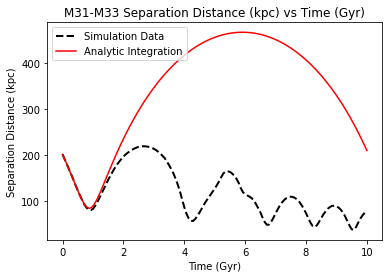

In [205]:
# Plot of the M31-M33 separation distance magnitude from the simulation and analytic integration
plt.plot(M31_orbit_t, M33_M31_separation_distance, c='black', lw=2, ls='--', \
         label='Simulation Data') # M31-M33 separation distance (simulation)
plt.plot(M33_analytic_orbit['t'], np.linalg.norm(M33_analytic_position, axis=0), c='red', \
         label='Analytic Integration') # M31-M33 separation distance (analytic)

plt.xlabel('Time (Gyr)')
plt.ylabel('Separation Distance (kpc)')
plt.title('M31-M33 Separation Distance (kpc) vs Time (Gyr)')
plt.legend(loc='upper left')

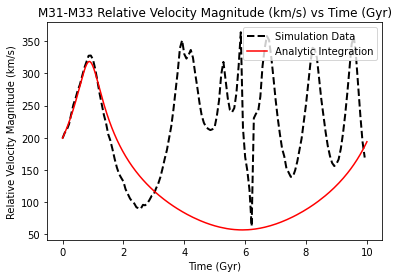

In [206]:
# Plot of the M31-M33 relative velocity magnitude from the simulation and analytic integration
plt.plot(M31_orbit_t, M33_M31_relative_velocity_magnitude, c='black', lw=2, ls='--', \
         label='Simulation Data') # M31-M33 relative speed (simulation)
plt.plot(M33_analytic_orbit['t'], np.linalg.norm(M33_analytic_velocity, axis=0), c='red', \
         label='Analytic Integration') # M31-M33 relative speed (analytic)

plt.title('M31-M33 Relative Velocity Magnitude (km/s) vs Time (Gyr)')
plt.xlabel('Time (Gyr)')
plt.ylabel('Relative Velocity Magnitude (km/s)')
plt.legend(loc='upper right')

# Analysis Questions
## 1. Plots (see above)
## 2. How do the plots compare?
The plots for both position and velocity are in relative agreement for approximately the first 1.5-2 Gyr of the simulation. This is consistent of what one might expect, given that some physical effects are neglected and the MW is absent from the analytical calculation. The results nonetheless match within a given timeframe, which means that the other factors either take time to accumulate or are only present later on.

## 3. What missing physics could make the difference?
One major missing piece is dynamical friction. The interaction between M33 and the "wake" of dark matter it leaves behind as it moves through the halo of M31 causes it to slow down over time and decay in its orbit. This can clearly be seen in the first plot, showing the separation distance between M33 and M31 (and eventually, the merger remnant), and even in the early parts of the velocity plot.

## 4. The MW is missing in these calculations. How might you include its effects?
One could account for the MW by adding additional terms in the computation of the total acceleration vector of the M33 COM. To do this, one would need to compute the relative positions of the MW and M33, and add additional terms to the M31Accel function with the corresponding scale lengths and masses of each component of the MW. At the same time, now, M31 would experience a significant acceleration due to the MW and vice versa, causing them to move toward each other (as one would expect from observations). This means that to incorporate the MW, one would also have to account for the motions of all 3 bodies, not just M33, which would add a layer of complexity. Using a similar integration technique, one could update the COM positions of all 3 bodies using accelerations calculated from the other 2. Even this would only work for a somewhat short timescale though, because the MW and M31 are not very well approximated by point masses once they start merging, and their extended structure starts to be significantly altered once they have a close approach and eventually merge.